In [ ]:
!pip install nltk
!pip install keras
!pip install tensorflow

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pandas as pd
import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_966929/1558013351.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/users/ys298/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
data_processed = pd.read_csv('tweets_preprocessed2.csv')
balanced_data = data_processed
non_suicide_data = data_processed[data_processed['class'] == 'non-suicide'].sample(n=5000)
suicide_data = data_processed[data_processed['class'] == 'suicide'].sample(n=5000)
# balanced_data = pd.concat([non_suicide_data, suicide_data])

In [ ]:
data_processed.head()
data_processed.shape

(10000, 6)

In [ ]:
data_processed[data_processed['class'] == 'non-suicide'].shape

(5000, 6)

## Data Preprocessing

In [ ]:
all_tokens = set(i.lower() for token in balanced_data["text"] for i in word_tokenize(token))
word_map = {token: idx for idx, token in enumerate(list(all_tokens))}
word_map['UNK'] = len(word_map)
word_map['PAD'] = len(word_map)+1

In [ ]:
def text_encoder(sentence, word_map):
    tokens = word_tokenize(sentence.lower())
    encode = [word_map.get(token, word_map['UNK']) for token in tokens]
    return encode

In [ ]:
class SuicideDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.vocab = vocab
        self.label_mapping = {
            'non-suicide': 0,
            'suicide': 1
        }
        self.labels = [self.label_mapping[label] for label in labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]
        encoded_sentence = text_encoder(sentence, self.vocab)

        return {
            'input_ids': torch.tensor(encoded_sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Pad the input_ids to the length of the longest sequence in the batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['label'] for item in batch]


    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=word_map['PAD'])
    labels = torch.stack(labels)
    text_lengths = torch.tensor([len(ids) for ids in input_ids], dtype=torch.long)

    return {
        'input_ids': padded_input_ids,
        'label': labels,
        'text_length': text_lengths
    }

In [ ]:
# Split data into balanced classes
train_non_suicide_data, test_non_suicide_data, train_non_suicide_label, test_non_suicide_label = train_test_split(
    non_suicide_data['text'], non_suicide_data['class'], test_size=0.2, random_state=42
)

train_suicide_data, test_suicide_data, train_suicide_label, test_suicide_label = train_test_split(
    suicide_data['text'], suicide_data['class'], test_size=0.2, random_state=42
)

train_data = pd.concat([train_non_suicide_data, train_suicide_data])
test_data = pd.concat([test_non_suicide_data, test_suicide_data])
train_label = pd.concat([train_non_suicide_label, train_suicide_label])
test_label = pd.concat([test_non_suicide_label, test_suicide_label])

# train_data, test_data, train_label, test_label = train_test_split(
#     balanced_data['text'], balanced_data['class'], test_size=0.2, random_state=42
# )

# Create datasets and dataloaders
train_dataset = SuicideDataset(train_data.to_numpy(), train_label.to_numpy(), word_map)
test_dataset = SuicideDataset(test_data.to_numpy(), test_label.to_numpy(), word_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [ ]:
train_data.shape

(8000,)

## Binary-Classfication LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab_size+1,embedding_dim)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid() # use sigmoid as activation function

    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True, enforce_sorted=False)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        hidden = self.batch_norm(hidden)
        outputs=self.sigmoid(self.fc(self.dropout(hidden)))

        return outputs

In [ ]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 2  # suicidal/non-suicidal
n_layers = 2
bidirectional = True
dropout = 0.3

In [ ]:
model = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
def accuracy(preds, y):
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

def evaluate(model, loader, criterion):
    """
    Evaluate the model on the validation or test set.

    Parameters:
    - model: The trained LSTM model.
    - loader: DataLoader for the validation or test set.
    - criterion: Loss function (e.g., CrossEntropyLoss).

    Returns:
    - A dictionary containing accuracy, ROC AUC, and the confusion matrix.
    """
    model.eval()
    all_labels = []  # True labels
    all_preds = []   # Predicted labels
    all_probs = []   # Probabilities for the positive class

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in loader:
            input_ids = batch['input_ids'].to(device)  # Input data
            labels = batch['label'].to(device)         # True labels
            text_length = batch['text_length'].to(device)  # Sequence lengths

            # Get model predictions
            outputs = model(input_ids, text_length)

            # Collect true labels and predictions
            all_labels.extend(labels.cpu().numpy())             # True labels
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Predicted labels
            all_probs.extend(outputs[:, 1].cpu().numpy())       # Probabilities for the positive class

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)  # Compute accuracy
    roc_auc = roc_auc_score(all_labels, all_probs)    # Compute ROC AUC
    cm = confusion_matrix(all_labels, all_preds)      # Compute confusion matrix

    return {
        'all_labels': all_labels,
        'all_probs': all_probs,
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

In [ ]:
EPOCH_NUMBER = 20
t_acc = []
t_loss = []
v_acc = []
roc = []
confusion = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train(model,train_loader,optimizer,criterion)

    result = evaluate(model,test_loader,criterion)

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(result['accuracy'])
    roc.append(result['roc_auc'])
    confusion.append(result['confusion_matrix'])

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tVal. Acc: {v_acc[-1]*100:.2f}%')
    print()

Epoch 1
	Train Loss: 0.579 | Train Acc: 70.88%
	 Val. Loss: 0.651 |  Val. Acc: 58.17%

Epoch 2
	Train Loss: 0.542 | Train Acc: 76.88%
	 Val. Loss: 0.586 |  Val. Acc: 71.15%



KeyboardInterrupt: 

In [ ]:
print("The best validation accuracy:", round(max(v_acc), 2))

The best validation accuracy: 0.83


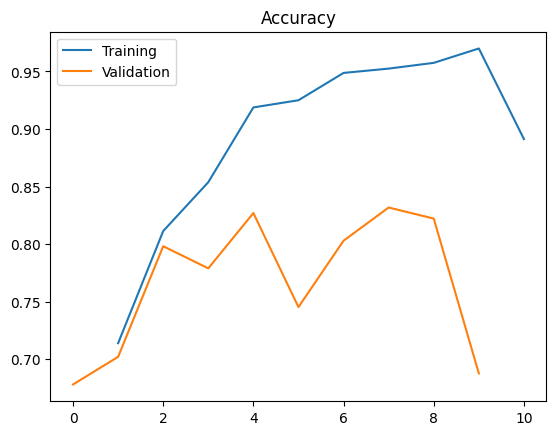

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), v_acc)
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, EPOCH_NUMBER+1))

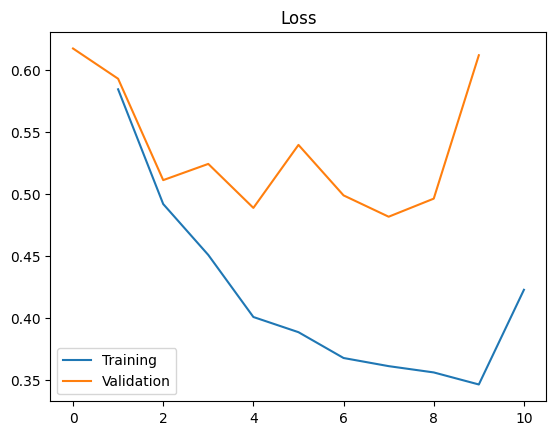

In [ ]:
# Extract final ROC data
final_labels = evaluate(model, test_loader, criterion)['all_labels']
final_probs = evaluate(model, test_loader, criterion)['all_probs']

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(labels, probs):
    """
    Plots an ROC curve.

    Parameters:
    - labels: True labels (ground truth)
    - probs: Predicted probabilities for the positive class
    """
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random classifier')


    # Add annotations
    plt.text(0.7, 0.5, 'Worse', fontsize=12, rotation=45)
    plt.text(0.4, 0.7, 'Better', fontsize=12, rotation=45)

    # Customize the plot
    plt.title('ROC Curve', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Plot the ROC curve
plot_roc_curve(final_labels, final_probs)

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), roc)
plt.title("Classification ROC")
plt.xlabel("Epoch")
plt.ylabel("ROC")
plt.xticks(range(1, EPOCH_NUMBER+1))

In [ ]:
import seaborn as sns
import numpy as np

sns.heatmap(confusion[-1], annot=True, fmt='', cmap='Blues')

## Regression LSTM

In [ ]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [ ]:
regression = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(regression.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regression = regression.to(device)

In [ ]:
def re_accuracy(preds, y, threshold=0.5):
    rounded_preds = (preds > threshold).float()  # Convert probabilities to binary predictions
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def re_train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = re_accuracy(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
def re_evaluate(model, loader, criterion):
    epoch_loss = 0.0
    all_labels = []
    all_preds = []
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length).squeeze(1)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())

    # Calculate metrics
    mae = mean_absolute_error(all_labels, all_preds)
    mse = mean_squared_error(all_labels, all_preds)

    return {
        'loss': epoch_loss / len(loader),
        'mae': mae,
        'mse': mse
    }


In [ ]:
EPOCH_NUMBER = 20
t_metrics = {'loss': []}
v_metrics = {'loss': [], 'mae': [], 'mse': []}

for epoch in range(1, EPOCH_NUMBER + 1):
    train_loss, _ = re_train(regression, train_loader, optimizer, criterion)
    valid_metrics = re_evaluate(regression, test_loader, criterion)

    # Store metrics
    t_metrics['loss'].append(train_loss)
    v_metrics['loss'].append(valid_metrics['loss'])
    v_metrics['mae'].append(valid_metrics['mae'])
    v_metrics['mse'].append(valid_metrics['mse'])

    print(f"Epoch {epoch}")
    print(f"\tTrain Loss: {train_loss:.3f}")
    print(f"\t Val. Loss: {valid_metrics['loss']:.3f} | Val. MAE: {valid_metrics['mae']:.3f} | Val. MSE: {valid_metrics['mse']:.3f}")

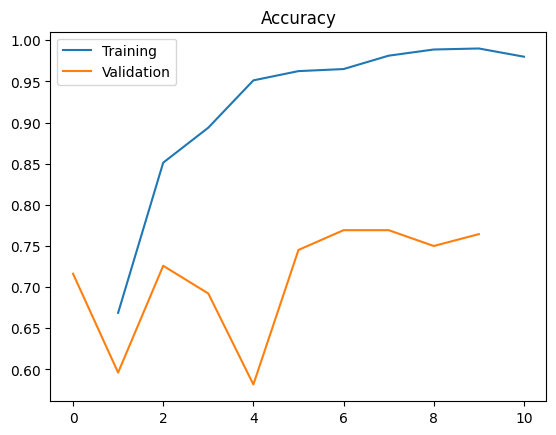

In [ ]:
# Plot trends over epochs
plt.figure(figsize=(8, 6))

# Plot validation MAE
plt.plot(range(1, EPOCH_NUMBER + 1), v_metrics['mae'], label='Validation MAE')

# Plot validation MSE
plt.plot(range(1, EPOCH_NUMBER + 1), v_metrics['mse'], label='Validation MSE')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Validation Metrics Over Epochs')
plt.legend()

# Ensure x-axis has a tick for each epoch
plt.xticks(ticks=range(1, EPOCH_NUMBER + 1))  # Set ticks to be integers from 1 to EPOCH_NUMBER

plt.show()

# Print final MAE and MSE
final_mae = v_metrics['mae'][-1]
final_mse = v_metrics['mse'][-1]
print(f"Final Validation MAE: {final_mae:.3f}")
print(f"Final Validation MSE: {final_mse:.3f}")


## LSTM with Attention Mechanism

To incorporate attention mechanism into the LSTM model, we compute attention weights over the LSTM output.

In [ ]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [ ]:
import torch
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )

        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)  # For attention weights
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layers
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        # self.sigmoid = nn.Sigmoid()  # Use sigmoid as activation function for binary classification

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Attention mechanism
        # mask = (text_lengths.unsqueeze(1) > torch.arange(output.size(1), device=text_lengths.device)).float()
        # attn_weights = self.attention(output).squeeze(-1) * mask
        attn_weights = self.attention(output)
        attn_weights = self.softmax(attn_weights.squeeze(-1))
        # print(f"Attention Weights: ", attn_weights)

        # Context vector as weighted sum of outputs
        context = torch.bmm(attn_weights.unsqueeze(1), output).squeeze(1)  # Shape: [batch_size, hidden_dim * 2]

        # Concatenate final hidden state and context vector
        hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)  # Final hidden state
        context_hidden = context + hidden  # Combine context and hidden state

        # Classification
        context_hidden = self.batch_norm(context_hidden)
        # print(f"Hidden Context shape: ", context_hidden.shape)
        # outputs = self.sigmoid(self.fc(self.dropout(context_hidden)))
        outputs = self.fc(self.dropout(context_hidden)).squeeze(1)

        return outputs


In [ ]:
def accuracy_att(preds, y):
  probs = torch.sigmoid(preds)
  rounded_preds = (probs > 0.5).float()
  correct = (rounded_preds == y).float()
  acc = correct.sum() / len(correct)
  return acc

In [ ]:
def train_att(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy_att(outputs, labels)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
model = LSTMWithAttention(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS GPU")
elif torch.cuda.is_available():
    print("using cuda...")
    device = torch.device("cuda")
else:
    print("using CPU")
    device = torch.device("cpu")
model = model.to(device)

using cuda...


In [ ]:
def evaluate_att(model,loader,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)

            loss = criterion(outputs, labels)
            acc = accuracy_att(outputs, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix

def evaluate_att_with_metrics(model, loader, criterion):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []
    epoch_loss = 0.0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item()

            all_labels.extend(labels.cpu().numpy().astype(int))
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(torch.sigmoid(outputs).cpu().numpy())

    print("Unique labels:", np.unique(all_labels))
    print("Unique predictions:", np.unique(all_preds))
    unique, counts = np.unique(all_labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print("Label distribution:", label_distribution)

    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"confusion matrix: ", cm)

    return {
        'loss': epoch_loss / len(loader),  # Average validation loss
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
    }

In [ ]:
EPOCH_NUMBER = 20
t_acc = []
t_loss = []
v_acc = []
v_loss = []
roc_auc = {}
fpr = {}
tpr = {}
cm = []

for epoch in range(1,EPOCH_NUMBER+1):

    train_loss,train_acc = train_att(model,train_loader,optimizer,criterion)

    valid_dict = evaluate_att_with_metrics(model,test_loader,criterion)
    valid_loss = valid_dict['loss']
    valid_acc = valid_dict['accuracy']
    roc_auc[epoch] = valid_dict['roc_auc']
    fpr[epoch] = valid_dict['fpr']
    tpr[epoch] = valid_dict['tpr']
    cm.append(valid_dict['confusion_matrix'])

    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)

    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 1000, 1: 1000}
confusion matrix:  [[804 196]
 [ 66 934]]
Epoch 1
	Train Loss: 0.403 | Train Acc: 83.03%
	 Val. Loss: 0.329 |  Val. Acc: 86.90%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 1000, 1: 1000}
confusion matrix:  [[875 125]
 [ 70 930]]
Epoch 2
	Train Loss: 0.264 | Train Acc: 89.84%
	 Val. Loss: 0.263 |  Val. Acc: 90.25%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 1000, 1: 1000}
confusion matrix:  [[883 117]
 [ 74 926]]
Epoch 3
	Train Loss: 0.198 | Train Acc: 92.74%
	 Val. Loss: 0.262 |  Val. Acc: 90.45%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 1000, 1: 1000}
confusion matrix:  [[897 103]
 [ 92 908]]
Epoch 4
	Train Loss: 0.133 | Train Acc: 95.24%
	 Val. Loss: 0.287 |  Val. Acc: 90.25%

Unique labels: [0 1]
Unique predictions: [0. 1.]
Label distribution: {0: 1000, 1: 1000}
confusion matrix:  [[900 100]
 [128 872]]
Ep

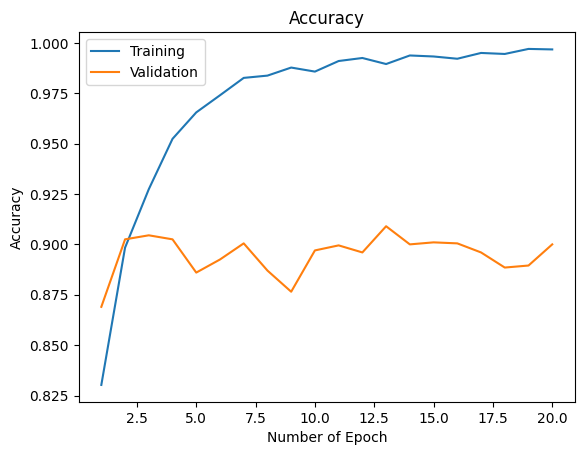

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc)
plt.plot(range(1, EPOCH_NUMBER+1), v_acc)
plt.title("Accuracy")
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy")
plt.legend(("Training", "Validation"))

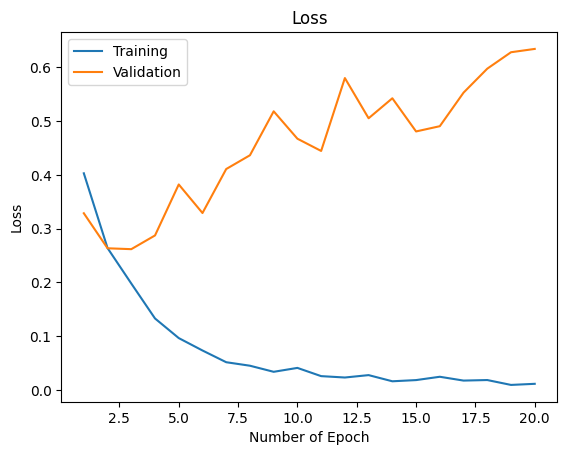

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_loss)
plt.plot(range(1, EPOCH_NUMBER+1), v_loss)
plt.title("Loss")
plt.xlabel("Number of Epoch")
plt.ylabel("Loss")
plt.legend(("Training", "Validation"))

The highest F1 score is 0.9103 at epoch 13


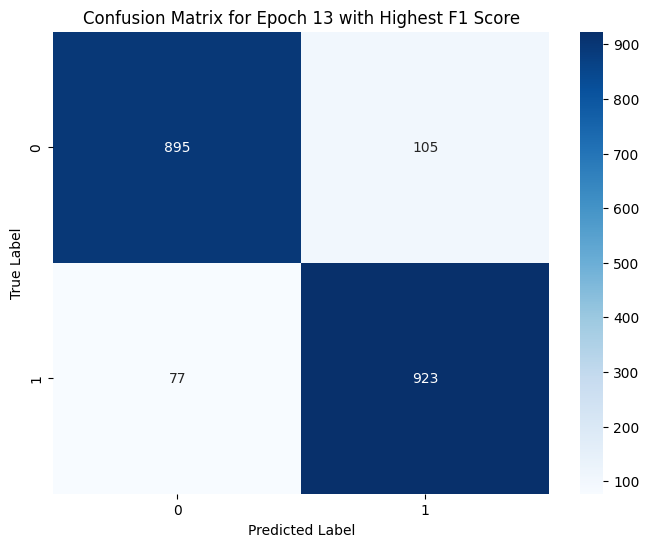

In [ ]:
# plot confusion matrix with the highest F1 score
import seaborn as sns

def calculate_metrics_from_cm(cm):
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]

    # Avoid division by zero
    precision_denominator = TP + FP
    recall_denominator = TP + FN

    precision = TP / precision_denominator if precision_denominator > 0 else 0
    recall = TP / recall_denominator if recall_denominator > 0 else 0

    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

# List to store manual F1 scores
f1_scores_manual = []

# Iterate over confusion matrices
for c in cm:
    precision, recall, f1 = calculate_metrics_from_cm(c)
    f1_scores_manual.append(f1)

# Find the epoch with the highest F1 score
best_epoch_index = np.argmax(f1_scores_manual)
best_f1_score = f1_scores_manual[best_epoch_index]
best_cm = cm[best_epoch_index]

print(f"The highest F1 score is {best_f1_score:.4f} at epoch {best_epoch_index + 1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title(f'Confusion Matrix for Epoch {best_epoch_index + 1} with Highest F1 Score')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [ ]:
tpr_flattened = [item for sublist in tpr for item in sublist]
tpr = np.array(tpr_flattened, dtype=float)

/tmp/ipykernel_966929/1241708953.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", color="red")


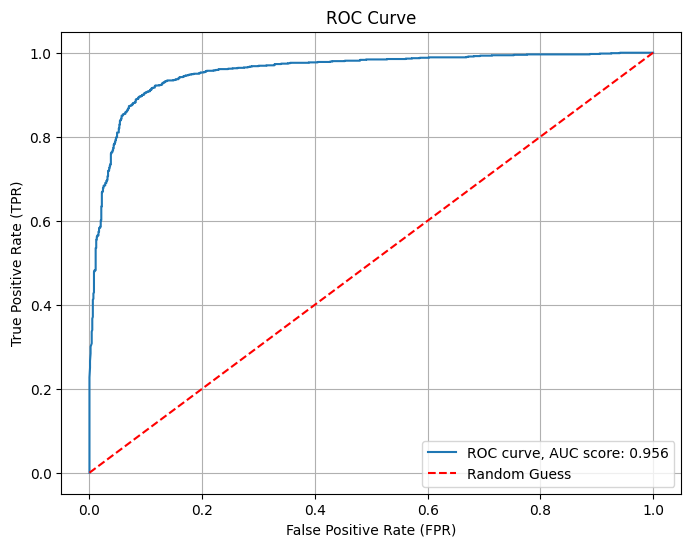

In [ ]:
# roc-auc curve for the last epoch
plt.figure(figsize=(8, 6))
plt.plot(fpr[20], tpr[20], label=f"ROC curve, AUC score: {roc_auc[20]:.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess", color="red")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Inference

### Binary Classfication

In [ ]:
def predict_sentence(sentence, model, word_map, device):
    # Preprocess the sentence
    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Get the length of the input sentence (for packing sequence)
    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

    # Interpret the result
    if prediction == 0:
        return "The sentence is classified as Non-Suicidal."
    else:
        return "The sentence is classified as Suicidal."

In [ ]:
sentence = "I feel hopeless."
result = predict_sentence(sentence, model, word_map, device)
print(result)

The sentence is classified as Suicidal.


### Regression

In [ ]:
def regression_predict(sentence, model, word_map, device):

    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)

    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        probability = torch.sigmoid(output).squeeze().item()  # Get the probability

    prediction = 1 if probability >= 0.5 else 0  # Threshold of 0.5
    if prediction == 0:
        result = f"The sentence is classified as Non-Suicidal with a probability of {1 - probability:.4f}."
    else:
        result = f"The sentence is classified as Suicidal with a probability of {probability:.4f}."

    return result

In [ ]:
sentence = "I feel sad."
result = regression_predict(sentence, regression, word_map, device)
print(result)

The sentence is classified as Suicidal with a probability of 0.6399.
